# ***Best Sentiment Classifier Transformers***

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='whitegrid')

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter

import re
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

import tensorflow as tf
import warnings
warnings.simplefilter('ignore')

In [2]:
#Importing data

import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df=pd.read_csv('/content/drive/MyDrive/train.tsv', sep='\t')
df_test=pd.read_csv('/content/drive/MyDrive/test_task2.tsv', sep='\t')

In [4]:
df.shape, df_test.shape

((5886, 3), (1653, 2))

In [5]:
df

,id,tweet,label
0,1,El Atlético resignado a perder HASHTAG 😔 http...,sadness
1,2,Leer proporciona una mejor visión del mundo 🤓 ...,joy
2,3,Amo a Arya Stark por encima de todas las cosas...,joy
3,4,Gracias HASHTAG es increíble que una niña logr...,others
4,5,Solo siento que hayamos perdido 24 escaños de ...,sadness
...,...,...,...
5881,5882,Pequeños gestos que puedes hacer por el medio ...,others
5882,5883,¿Sabías que de las dos coronaciones que se cel...,surprise
5883,5884,Mientras reflexionamos sobre lo duro que es es...,anger
5884,5885,La fachada de la catedral de Notre Dame fue “s...,sadness


In [6]:
df_test

,id,tweet
0,1,El 26 de octubre de 2018 grabé este vídeo dura...
1,2,Se incendió HASHTAG en USER pese a todas las m...
2,3,Me da tristeza saber que fue incendiado y toda...
3,4,Hoy es un día triste en HASHTAG HASHTAG catedr...
4,5,¿Cómo pudo pasar algo así HASHTAG? Una verdade...
...,...,...
1648,1661,Se han dado cuenta que todos esos mentirosos c...
1649,1662,USER USER Pocas cosas son tan imbéciles como l...
1650,1663,Es imposible describir lo que se vive en HASHT...
1651,1664,Dembele de mierda piernas chuecas regalaste do...


In case there is a null or empty value in any column we should have to get rid of it, in order to find it out we will use info() as follows:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5886 entries, 0 to 5885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5886 non-null   int64 
 1   tweet   5886 non-null   object
 2   label   5886 non-null   object
dtypes: int64(1), object(2)
memory usage: 138.1+ KB


In [7]:
df.isnull().sum()

id        0
tweet     0
label     0
dtype: int64

In [8]:
df = df.rename({'label ': 'label'}, axis=1) #Rename the column label
df = df[~df.label.str.contains("others")]
df = df[~df.label.str.contains("disgust")]

In [9]:
label_map = {
    'joy ': 0,
    'sadness ': 1,
    'anger ': 2,
    'surprise ': 3,
    'fear ': 4,
}

df['label'] = df['label'].map(label_map)
df

,id,tweet,label
0,1,El Atlético resignado a perder HASHTAG 😔 http...,1
1,2,Leer proporciona una mejor visión del mundo 🤓 ...,0
2,3,Amo a Arya Stark por encima de todas las cosas...,0
4,5,Solo siento que hayamos perdido 24 escaños de ...,1
5,6,Solo con ver con la intensidad que agitan las ...,0
...,...,...,...
5879,5880,IMPOSIBLE DE VER: Melisandre podría estar ya e...,3
5882,5883,¿Sabías que de las dos coronaciones que se cel...,3
5883,5884,Mientras reflexionamos sobre lo duro que es es...,2
5884,5885,La fachada de la catedral de Notre Dame fue “s...,1


In [10]:
df.label.value_counts()

0    1270
1     706
2     600
3     241
4      67
Name: label, dtype: int64

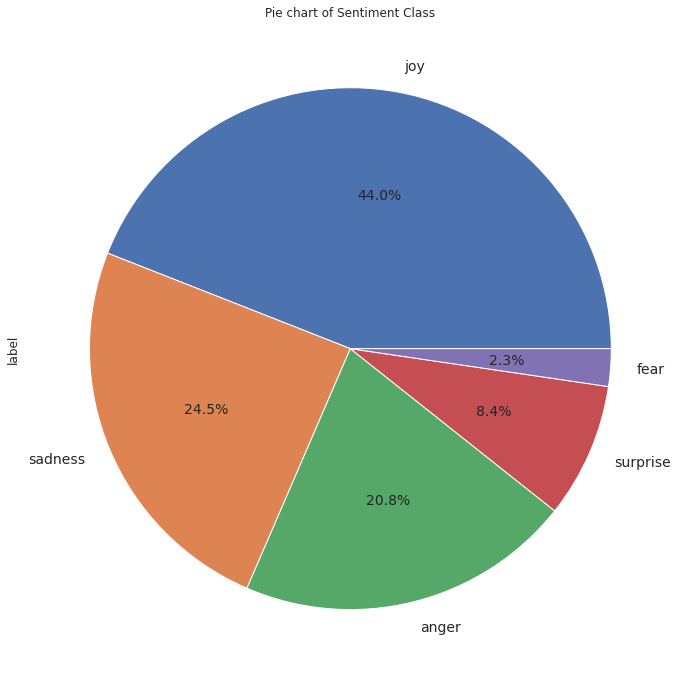

In [11]:
df2=df.copy(deep=True)
pie1=pd.DataFrame(df2['label'].replace(0,'joy').replace(1,'sadness').replace(2,'anger').replace(3,'surprise').replace(4,'fear').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Sentiment Class',y = 'label', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))

The label is considerably unbalanced, only 'joy' corresponds to more than 50% of instances.  Early we can say the class to be predicted will be sidetracked toward the more frequent classes, this is why we need a text balancing technique just like 'SMOTE' for numerical features.

Time now to find out the number of words in reviews, in order to understand a bit better we will plot histograms for each class

Text(0.5, 0.98, 'Histogram number of words in tweets')

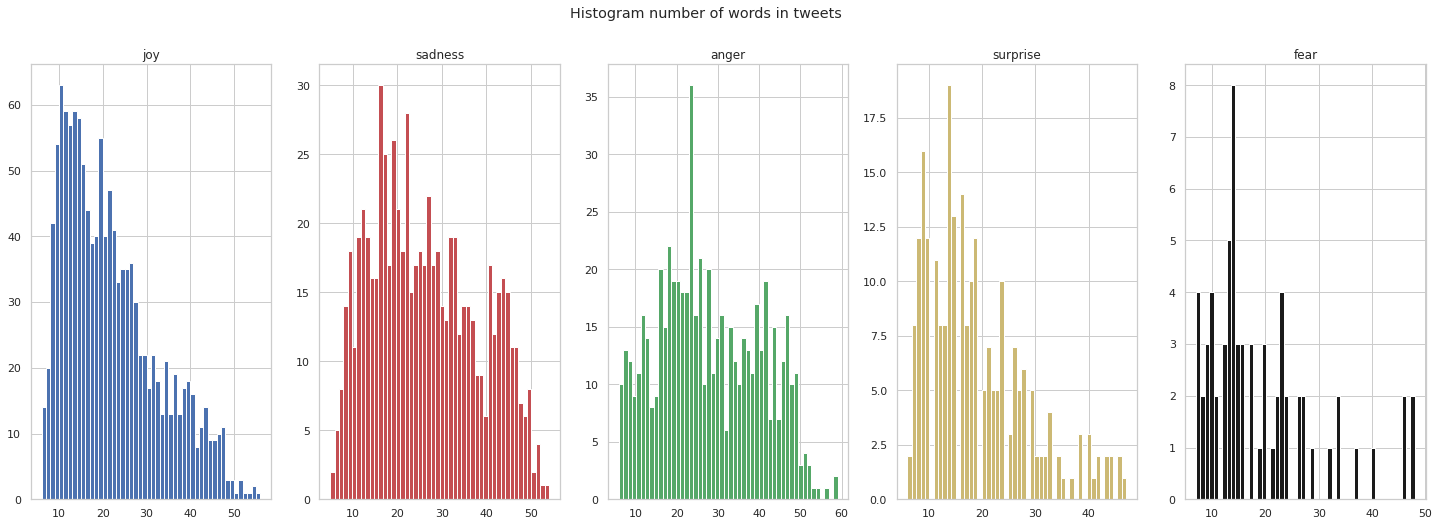

In [12]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25,8))

ax1.hist(df[df['label'] == 0]['tweet'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('joy')

ax2.hist(df[df['label'] == 1]['tweet'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('sadness')

ax3.hist(df[df['label'] == 2]['tweet'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('anger')

ax4.hist(df[df['label'] == 3]['tweet'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('surprise')

ax5.hist(df[df['label'] == 4]['tweet'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('fear')

f.suptitle('Histogram number of words in tweets')

# ***Preprocesamiento***

In [13]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import nltk

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

In [17]:
def strip_all_entities(text):
    entity_prefixes = ['@','#', '¿', '¡']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [18]:
df['tweet'] = df['tweet'].apply(lambda x: strip_links(x))

In [19]:
df['tweet'] = df['tweet'].apply(lambda x: strip_all_entities(x))

In [20]:
df['tweet'] = df['tweet'].str.replace(r'HASHTAG', '', regex=True)
df['tweet'] = df['tweet'].str.replace(r'USER', '', regex=True)

In [21]:
def convert_to_lower(text):
    return text.lower()

In [22]:
df['tweet'] = df['tweet'].apply(lambda x: convert_to_lower(x))

In [23]:
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

In [24]:
df['tweet'] = df['tweet'].apply(lambda x: remove_numbers(x))

In [25]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [26]:
df['tweet'] = df['tweet'].apply(lambda x: remove_punctuation(x))

In [27]:
from nltk import word_tokenize #method that will perform text tokenization.

In [28]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
stopword_es = nltk.corpus.stopwords.words('spanish')
stopword = stopword_es

def remove_stopwords(text):
    removed = []
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stopword:
            removed.append(tokens[i])
    return " ".join(removed)

In [30]:
df['tweet'] = df['tweet'].apply(lambda x: remove_stopwords(x))

In [31]:
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

In [32]:
df['tweet'] = df['tweet'].apply(lambda x: remove_extra_white_spaces(x))

In [33]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import emoji

In [35]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                    u"\U0001F600-\U0001F64F" #emoticons
                    u"\U0001F300-\U0001F5FF" #symbols and pictographs
                    u"\U0001F680-\U0001F6FF" #transport and map symbols
                    u"\U0001F1E0-\U0001F1FF" #flags (ios)
                    u"\U00002702-\U000027B0" 
                    u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [36]:
df['tweet'] = df['tweet'].apply(lambda x: remove_emoji(x))

In [37]:
pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
from cleantext import clean
df['tweet'] = df['tweet'].apply(lambda x: clean(x, no_emoji = True))

In [41]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec


from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [39]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

Train - Test split

In [42]:
X = df['tweet']
y = df['label']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

Oversampling of training set

In [45]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['tweet', 'label']);

In [46]:
X_train = train_os['tweet'].values
y_train = train_os['label'].values

In [47]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 914],
       [  1, 914],
       [  2, 914],
       [  3, 914],
       [  4, 914]])

# ***Modeling***

## ***Naive Bayes baseline model***

In [48]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [49]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [50]:
nb_clf = MultinomialNB()

In [51]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [52]:
nb_pred = nb_clf.predict(X_test_tf)

In [56]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.87      0.67      0.76       254
           1       0.65      0.74      0.70       141
           2       0.59      0.51      0.54       120
           3       0.31      0.58      0.40        48
           4       0.21      0.36      0.26        14

    accuracy                           0.64       577
   macro avg       0.52      0.57      0.53       577
weighted avg       0.69      0.64      0.66       577



The performance scores of the algorithm is very good, with an overall accurcy of 64%.
We can observe how the predictions for the more populated classes have very high F1 scores (over 70%), while for the class "4" the score is much lower.

## ***PyTorch Bi-LSTM RNN***

In [64]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [69]:
vocabulary, tokenized_column = Tokenize(df["tweet"], 80)

*Word Embedding by Word2Vec*

Next, we will create a word embedding matrix using the original text tweets and the pre trained model Word2vec.
First, we create a list of words from the X_train vector created before.

In [70]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [71]:
EMBEDDING_DIM = 200

In [73]:
word2vec_model = Word2Vec(Word2vec_train_data, size=EMBEDDING_DIM)

In [74]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [75]:
#define empty embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (7974, 200)


Train - Validation - Test split

In [76]:
X = tokenized_column
y = df['label'].values


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [78]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [79]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 914],
       [  1, 508],
       [  2, 432],
       [  3, 174],
       [  4,  48]])

In [80]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [81]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 914],
       [  1, 914],
       [  2, 914],
       [  3, 914],
       [  4, 914]])

PyTorch datasets and dataloaders

In [82]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [83]:
BATCH_SIZE = 32

In [84]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

*PyTorch LSTM modeling*

In [85]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 3e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 5 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [86]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [87]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(7974, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [88]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

In [89]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 16.964286).  Saving model ...
	Train_loss : 1.5448 Val_loss : 1.5376
	Train_acc : 31.690% Val_acc : 16.964%
Epoch 2:Validation accuracy increased (16.964286 --> 50.000000).  Saving model ...
	Train_loss : 1.0391 Val_loss : 1.2163
	Train_acc : 59.837% Val_acc : 50.000%
Epoch 3:Validation accuracy increased (50.000000 --> 55.803571).  Saving model ...
	Train_loss : 0.5778 Val_loss : 1.1829
	Train_acc : 83.275% Val_acc : 55.804%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.3001 Val_loss : 1.2426
	Train_acc : 92.099% Val_acc : 55.357%
Epoch 5:Validation accuracy increased (55.803571 --> 58.928571).  Saving model ...
	Train_loss : 0.1647 Val_loss : 1.3979
	Train_acc : 96.809% Val_acc : 58.929%


In [90]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

*LSTM Testing*

In [91]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [92]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

           0       0.61      0.76      0.68       254
           1       0.67      0.66      0.67       141
           2       0.47      0.35      0.40       119
           3       0.40      0.21      0.27        48
           4       1.00      0.29      0.44        14

    accuracy                           0.60       576
   macro avg       0.63      0.45      0.49       576
weighted avg       0.59      0.60      0.58       576



In [95]:
sentiments = ["joy","sadness","anger","surprise","fear"]

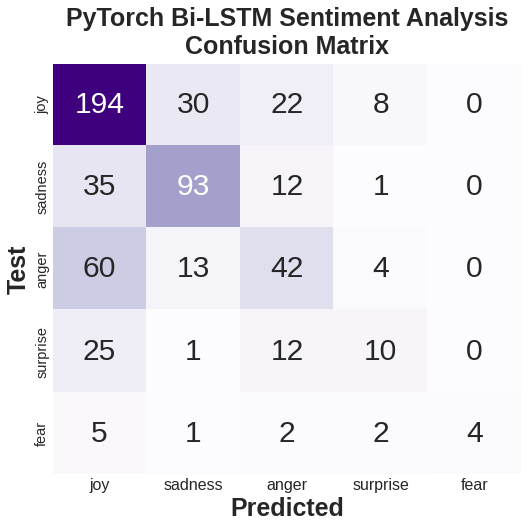

In [96]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

The performance scores of the algorithm have an overall accuracy of 60%.
In particular, the F1 scores for the more populated classes are over 65%

# ***BERT Classification***

In [97]:
X = df['tweet'].values
y = df['label'].values

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [99]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [100]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [101]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [102]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 914],
       [  1, 914],
       [  2, 914],
       [  3, 914],
       [  4, 914]])

In [104]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 2.6 MB/s 
     |████████████████████████████████| 163 kB 46.5 MB/s 
     |████████████████████████████████| 6.6 MB 32.0 MB/s 


In [107]:
from transformers import TFBertModel,  BertConfig, BertTokenizer

*BERT Tokenization*

In [108]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [109]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [110]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  68


In [111]:
MAX_LEN = 70

In [112]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


*Data preprocessing for PyTorch BERT model*

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

In [113]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

Dataloaders

In [114]:
batch_size = 32

In [115]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

*BERT Modeling*

In [125]:
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

In [126]:
%%time
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Add dense layers to perform the classification
        self.classifier = nn.Sequential(
            nn.Linear(n_input,  n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )
        # Add possibility to freeze the BERT model
        # to avoid fine tuning BERT params (usually leads to worse results)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input data to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 0 ns, sys: 56 µs, total: 56 µs
Wall time: 73.4 µs


In [127]:
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)
    
    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )
    
    ### Set up learning rate scheduler ###

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Defint the scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [128]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

In [129]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


*BERT Training*

In [131]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [132]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   1.294926   |  2154.75 
   142    |   0.734746   |  879.62  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   1.130398    |  0.947708  |       63.39       |  3081.99 
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.490446   |  2151.45 
   142    |   0.434739   |  873.61  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.474085    |  1.079234  |       59.88

*BERT Prediction*

In [133]:
def bert_predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

In [134]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [135]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

         joy       0.82      0.70      0.76       254
     sadness       0.69      0.80      0.74       141
       anger       0.53      0.60      0.56       120
    surprise       0.39      0.42      0.40        48
        fear       0.75      0.43      0.55        14

    accuracy                           0.68       577
   macro avg       0.64      0.59      0.60       577
weighted avg       0.69      0.68      0.68       577



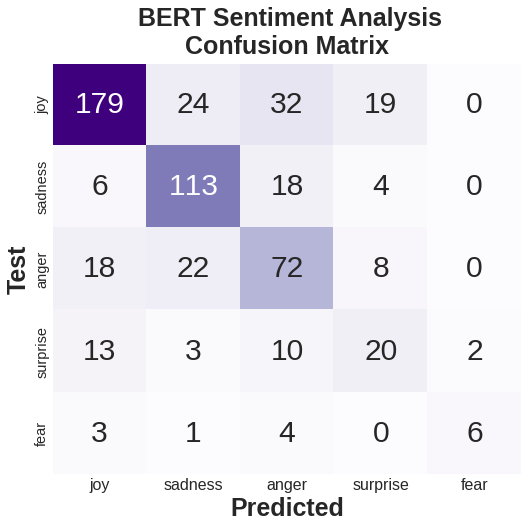

In [136]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)